# Autoregressive Model


In an autoregression model, we forecast using a linear combination of <em>past values</em> of the variable. The term <em>autoregression</em> describes a regression of the variable against itself. An autoregression is run against a set of <em>lagged values</em> of order $p$.



### $y_{t} = c + \phi_{1}y_{t-1} + \phi_{2}y_{t-2} + \dots + \phi_{p}y_{t-p} + \varepsilon_{t}$

where $c$ is a constant, $\phi_{1}$ and $\phi_{2}$ are lag coefficients up to order $p$ and $\varepsilon_{t}$ is white noise.

For example, an <strong>AR(1)</strong> model would follow the formula

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = c + \phi_{1}y_{t-1} + \varepsilon_{t}$

whereas an <strong>AR(2)</strong> model would follow the formula

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = c + \phi_{1}y_{t-1} + \phi_{2}y_{t-2} + \varepsilon_{t}$

and so on.

Note that the lag coefficients are usually less than one, as we usually restrict autoregressive models to stationary data.<br>
<br>Specifically, for an <strong>AR(1)</strong> model: $-1 \lt \phi_1 \lt 1$<br>
and for an <strong>AR(2)</strong> model: $-1 \lt \phi_2 \lt 1, \ \phi_1 + \phi_2 \lt 1, \ \phi_2 - \phi_1 \lt 1$<br>

Models <strong>AR(3)</strong> and higher become mathematically very complex. Fortunately statsmodels does all the heavy lifting for us.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.ar_model import AutoReg # We are using the in-built module for comparision purpose

import warnings
warnings.filterwarnings('ignore')

In [2]:
def mean_absolute_percentage_error(y_true,y_pred):
    return round(np.mean(np.abs((y_true-y_pred)/y_true))*100,2)     

I have used AirPassengers Traffic dataset. It is freely available , you can download it from AnalyticsVidhya website.

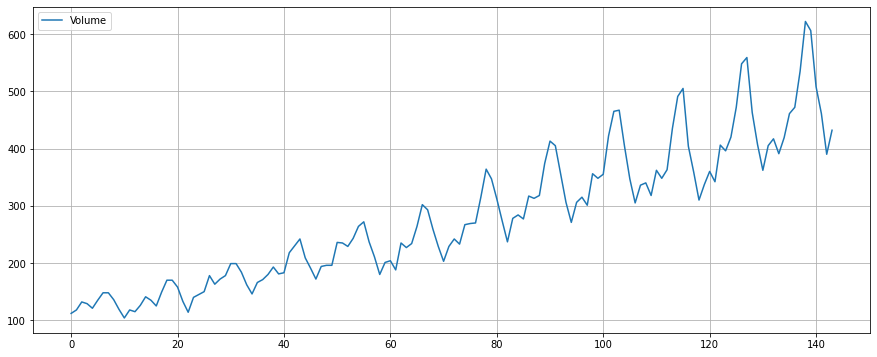

In [3]:
df = pd.read_csv('data.csv',parse_dates=['Month'],index_col='Month')
df.columns=['Volume']
df.reset_index(drop=True,inplace=True)

plt.figure(figsize=(15,6))
plt.plot(df,label='Volume')
plt.legend()
plt.grid()
plt.show()

The above graph looks non-stationary (you will get to know this term in next chapter). <br> But we will still use it, as it is just for learning purpose.. :)

In [4]:
class AR:
    
    def __init__(self,data=None,p=None):
        
        self.p = p
        self.data = data.copy()
        self.model  = None
        self.params = {}
    
    def fit(self):
        # Generate Lag variables upto max lags.
        for i in range(1,self.p+1):
            self.data['Lag_%d'%i] = self.data.Volume.shift(i)
        
        self.data = self.data.dropna().reset_index(drop=True)
        
        # We have all the necessary features to build a model now
        self.model = LinearRegression()
        
        # Input Varible(s) - Lag variables , Predictor Variable - Original Series
        self.model.fit(self.data.drop('Volume',axis=1),self.data.Volume)
        
        self.params['Intecept'] = self.model.intercept_
        
        for i,val in enumerate(list(self.model.coef_)):
            self.params['Lag_%d'%(i+1)] =  val
        
        self.params = pd.Series(self.params).T
        #return self.data
    
        
    def predict(self,n_preds=20):
        
        X = self.data.copy()
        
        for i in range(n_preds):
            
            X = X.append(pd.Series(), ignore_index=True)
            
            for j in range(1,self.p+1):
                
                if j==1:
                    val  =  X.loc[len(X)-2,'Volume']
                else:
                    val =   X.loc[len(X)-2,'Lag_%d'%(j-1)]
                    
                X.loc[len(X)-1,'Lag_%d'%(j)] = val
                
                X.loc[len(X)-1,"Volume"] = X.iloc[len(X)-1,list(range(1,self.p+1))].dot(self.model.coef_.T) + self.model.intercept_               
                
          
        return X[len(self.data):].Volume.reset_index(drop=True)
        
        

### Split the Dataset into Train and Test Data

In [5]:
train_size = (int)(0.8 * df.shape[0])

train_df = df[:train_size].copy()
test_df = df[train_size:].reset_index(drop=True)

print(train_df.shape,test_df.shape)

(115, 1) (29, 1)


#  AR(1) Model

Let's start building AR(1) model. i.e., lags considered = 1


In [6]:
max_lag = 1
model1 = AR(data=train_df.copy(),p=max_lag) # This is the model created by us.
model_2 = AutoReg(train_df,lags=max_lag)    # This is the AutoReg module from statsmodels library

model1.fit()
model2 = model_2.fit()

In [7]:
print(model1.params)
print(model2.params)

Intecept    7.914202
Lag_1       0.980695
dtype: float64
intercept    7.914202
Volume.L1    0.980695
dtype: float64


In [8]:
pred1 = model1.predict(n_preds=len(test_df)) 
pred2 = model2.predict(start=len(train_df),end=len(train_df)+len(test_df)-1).reset_index(drop=True)

In [9]:
print("Model 1 - MAPE = {}%".format(mean_absolute_percentage_error(test_df.Volume.values,pred1)))
print("Model 2 - MAPE = {}%".format(mean_absolute_percentage_error(test_df.Volume.values,pred2)))

Model 1 - MAPE = 17.92%
Model 2 - MAPE = 17.92%


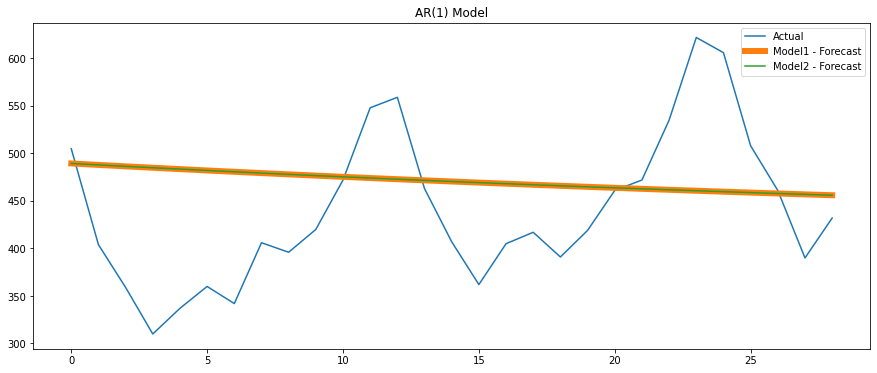

In [10]:
plt.figure(figsize=(15,6))
plt.plot(test_df.Volume,label="Actual")
plt.plot(pred1,label='Model1 - Forecast',linewidth='6')
plt.plot(pred2,label='Model2 - Forecast')
plt.title("AR({}) Model".format(max_lag))
plt.legend()
plt.show()

That looks really bad..  It didnt capture anything..<br>
But it is not so bad according to MAPE values, as they say Simple Mean sometimes wins the battle..<br>

But our objective is something else, so let's continue with more lags..

# AR(2) Model

In [11]:
max_lag = 2
model1 = AR(data=train_df.copy(),p=max_lag)
model_2 = AutoReg(train_df,lags=max_lag)

model1.fit()
model2 = model_2.fit()

In [12]:
print(model1.params)
print(model2.params)

Intecept    11.307877
Lag_1        1.269679
Lag_2       -0.306874
dtype: float64
intercept    11.307877
Volume.L1     1.269679
Volume.L2    -0.306874
dtype: float64


In [13]:
pred1 = model1.predict(n_preds=len(test_df)) 
pred2 = model2.predict(start=len(train_df),end=len(train_df)+len(test_df)-1).reset_index(drop=True)

In [14]:
print("Model 1 - MAPE = {}%".format(mean_absolute_percentage_error(test_df.Volume.values,pred1)))
print("Model 2 - MAPE = {}%".format(mean_absolute_percentage_error(test_df.Volume.values,pred2)))

Model 1 - MAPE = 20.26%
Model 2 - MAPE = 20.26%


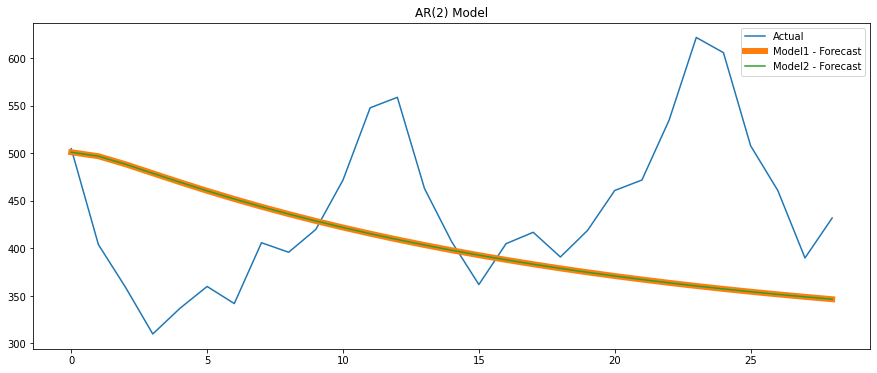

In [15]:
plt.figure(figsize=(15,6))
plt.plot(test_df.Volume,label="Actual")
plt.plot(pred1,label='Model1 - Forecast',linewidth='6')
plt.plot(pred2,label='Model2 - Forecast')
plt.title("AR({}) Model".format(max_lag))
plt.legend()
plt.show()

Not much improvement..  Let's try higher lag value

# AR(9) Model

In [16]:
max_lag = 9
model1 = AR(data=train_df.copy(),p=max_lag)
model_2 = AutoReg(train_df,lags=max_lag)

model1.fit()
model2 = model_2.fit()

In [17]:
print(model1.params)
print(model2.params)

Intecept    4.593166
Lag_1       1.192830
Lag_2      -0.516553
Lag_3       0.324145
Lag_4      -0.537294
Lag_5       0.528995
Lag_6      -0.188375
Lag_7       0.132109
Lag_8      -0.484584
Lag_9       0.555884
dtype: float64
intercept    4.593166
Volume.L1    1.192830
Volume.L2   -0.516553
Volume.L3    0.324145
Volume.L4   -0.537294
Volume.L5    0.528995
Volume.L6   -0.188375
Volume.L7    0.132109
Volume.L8   -0.484584
Volume.L9    0.555884
dtype: float64


In [18]:
pred1 = model1.predict(n_preds=len(test_df)) 
pred2 = model2.predict(start=len(train_df),end=len(train_df)+len(test_df)-1).reset_index(drop=True)

In [19]:
print("Model 1 - MAPE = {}%".format(mean_absolute_percentage_error(test_df.Volume.values,pred1)))
print("Model 2 - MAPE = {}%".format(mean_absolute_percentage_error(test_df.Volume.values,pred2)))

Model 1 - MAPE = 9.91%
Model 2 - MAPE = 9.91%


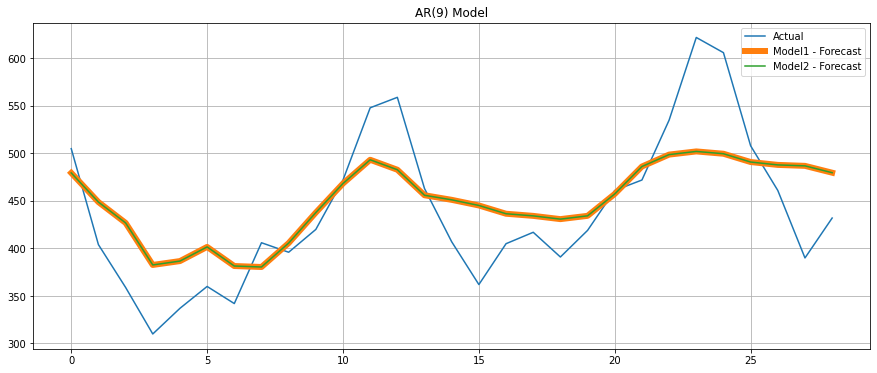

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_df.Volume,label="Actual")
plt.plot(pred1,label='Model1 - Forecast',linewidth='6')
plt.plot(pred2,label='Model2 - Forecast')
plt.title("AR({}) Model".format(max_lag))
plt.legend()
plt.grid()
plt.show()

Hurray.....!!!! Now that's a better one.<br> 

But in general, there are techniques to chose the value of p .<br>

We have PACF which we will discuss in next topics.. 



### Note:

I really enjoyed preparing this notebook..<br>
Hope you like it.. <br>

Also, if you observe both models , both have small difference in their forecasted values.. <br>
This might be due to the error term in the equation or might be something else. I have to still figure out that. :)





#### (Extra) Let's forecast for longer periods like 100 weeks ahead using both models..

In [21]:
max_lag = 12
n_preds = 100

In [22]:
model1 = AR(data=train_df.copy(),p=max_lag)
model_2 = AutoReg(train_df,lags=max_lag)

model1.fit()
model2 = model_2.fit()

In [23]:
pred1 = model1.predict(n_preds=n_preds)
pred2 = model2.predict(start=len(train_df),end=len(train_df)+n_preds-1).reset_index(drop=True)

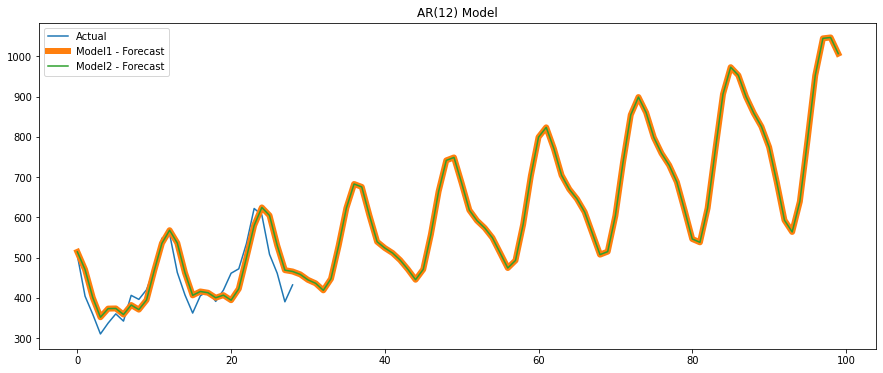

In [24]:
plt.figure(figsize=(15,6))
plt.plot(test_df.Volume,label="Actual")
plt.plot(pred1,label='Model1 - Forecast',linewidth='6')
plt.plot(pred2,label='Model2 - Forecast')
plt.title("AR({}) Model".format(max_lag))
plt.legend()
plt.show()

Awesome...!! 

<b>Note:</b><br>

Next we will discuss about ARMA and then later ARIMA.. <br>
AR in ARMA is the one you learnt in this notebook.. , and coming to MA part , it is also similar but instead of previous lag values in the equation we have error terms. which are MA components basically.. <br> 
Lets discuss MA in the next chapter itself.

Thanks..!! :)
